In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from skimage.metrics import mean_squared_error as mse, structural_similarity as ssim


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

# Hyperparameters
lr = 0.0002
batch_size = 32
num_epochs = 20000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders()

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Initialize BCE loss for Discriminator
criterion_d = nn.BCELoss()

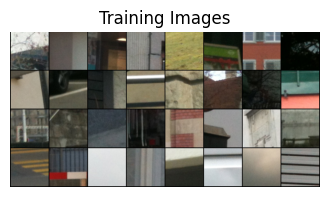

In [3]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [6]:
# Labels
real_labels = torch.ones(32, 1).to(device)
fake_labels = torch.zeros(32, 1).to(device)

for i in range(2):
    for phone_imgs, dslr_imgs in train_dataloader:
        phone_imgs = phone_imgs.to(device)
        dslr_imgs = dslr_imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Generate enhanced images
        enhanced_imgs = generator(phone_imgs)

        # Calculate SSIM loss
        ssim_loss = torch.tensor(-ssim(dslr_imgs.cpu().numpy(), enhanced_imgs.cpu().detach().numpy(), channel_axis=1, win_size=11, data_range=1)).to(device)

        # Update Generator
        ssim_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        output = discriminator(dslr_imgs)
        loss_real = criterion_d(output, real_labels)
        
        # Fake images
        output = discriminator(enhanced_imgs.detach())
        loss_fake = criterion_d(output, fake_labels)

        # Total loss and update
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_D.step()
    print(f"Epoch [{i + 1}/{i}] Generator SSIM Loss: {ssim_loss.item()}, Discriminator BCE Loss: {loss_d.item()}")


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn